In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from pathlib import Path

In [50]:
CURRENT_DIR = Path.cwd()

In [51]:
filepath = os.path.join(CURRENT_DIR, "S03_residual_stress_merge.xlsx")
dfm = pd.read_excel(filepath).rename(
    columns={"Sigma(x)": "sigma_x_pre", "FWHM": "FWHM_pre"}
)
dfm
dfm_imputed = dfm.copy()


In [52]:
default_cols = ["section", "sample_no", "location"]

In [53]:
dfm

,idx_excel_post,section,sample_no,location,R,W,D,sigma_x_post,FWHM_post,idx_excel_pre,sigma_x_pre,FWHM_pre,diff_sigma_x
0,4,AA5052,1,1,1400,60,10,13,2.55,2,-15,2.50,28
1,25,AA5052,2,1,1400,60,15,16,2.51,9,2,2.47,14
2,46,AA5052,3,1,1400,60,20,19,2.47,16,9,2.48,10
3,67,AA5052,4,1,1400,70,10,20,2.45,23,10,2.48,10
4,88,AA5052,5,1,1400,70,15,6,2.47,30,0,2.49,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,1050,Center,50,7,1600,70,15,2,2.45,0,0,0.00,2
1130,1071,Center,51,7,1600,70,20,2,2.45,0,0,0.00,2
1131,1092,Center,52,7,1600,80,10,5,2.54,0,0,0.00,5
1132,1113,Center,53,7,1600,80,15,1,2.41,0,0,0.00,1


# Prototype


,section,sample_no,location,sigma_x_pre,idx_excel_pre
744,AA6061,43,5,-109,300
553,AA6061,14,4,-92,96
226,AA6061,11,2,-85,73
746,AA6061,45,5,-83,314
216,AA6061,1,2,-79,3
391,AA6061,14,3,-78,95
874,AA6061,11,6,-77,77
565,AA6061,26,4,-76,180
722,AA6061,21,5,-73,146
269,AA6061,54,2,-72,374


Imputing idx_excel 48 at location 5, section AA6061 with mean value: 29.78846153846154
Imputing idx_excel 300 at location 5, section AA6061 with mean value: 29.78846153846154


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17180\2890511804.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.78846153846154' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfm_imputed.loc[idx, y] = mean_val


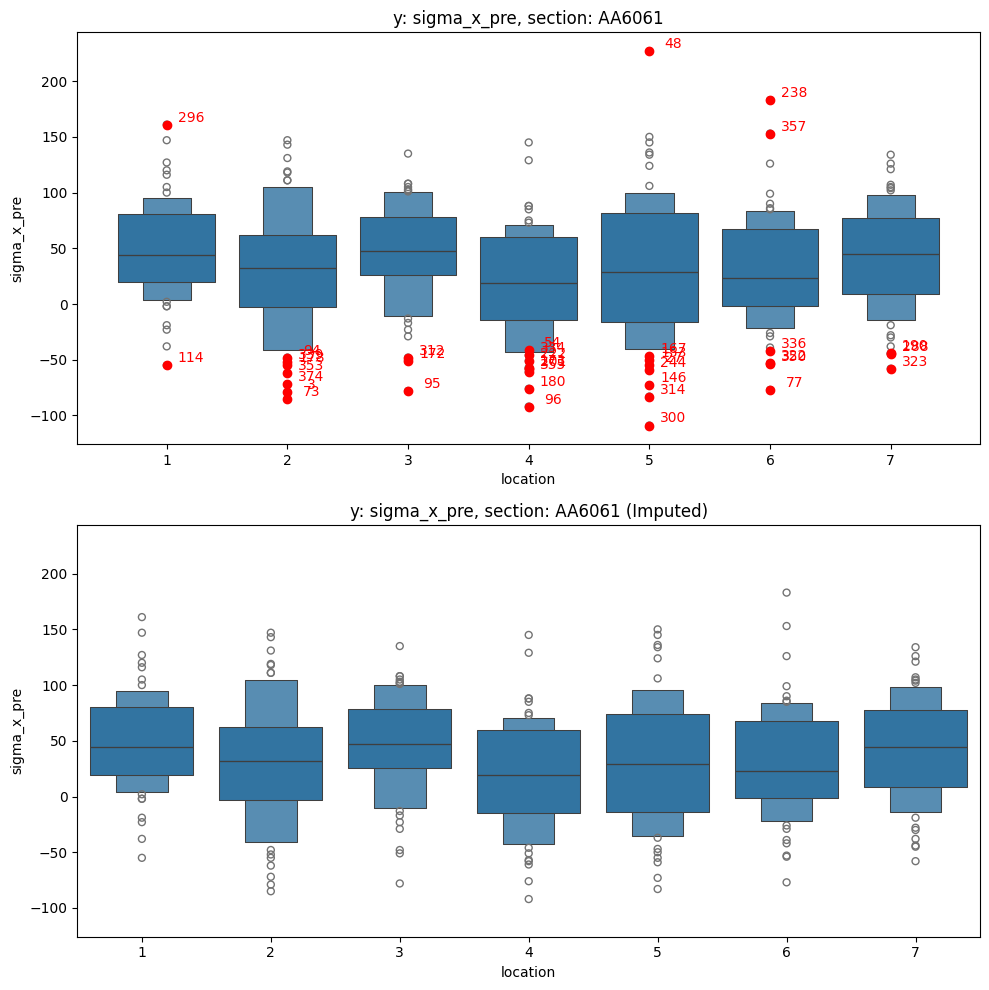

In [54]:
section = "AA6061"
y = "sigma_x_pre"
max_val = 150
min_val = -40
impute_idx_excels = [48, 300]

# Filter data for specific section
filt = dfm["section"].isin([section])
idx_excel_col = "idx_excel_pre" if "pre" in y else "idx_excel_post"

# Identify rows with high residual stress in pre-weld data for further investigation
filt_val = (dfm[y] > max_val) | (dfm[y] < min_val)
dfm_outlier = dfm[filt & filt_val][[*default_cols, y, idx_excel_col]].sort_values(by=y)
display(dfm_outlier)

# Data for specific section

# Impute outlier values with median of respective location and section
# First convert index_excel to index
dfm_section = dfm[dfm["section"] == section]
impute_idxs = dfm_section[dfm_section[idx_excel_col].isin(impute_idx_excels)].index.tolist()
for idx, idx_excel in zip(impute_idxs, impute_idx_excels):
    _location = dfm.loc[idx, "location"]
    _section = dfm.loc[idx, "section"]
    filt_idx = (
        (dfm["location"] == _location)
        & (dfm["section"] == _section)
        & (~dfm.index.isin(impute_idxs))
    )
    mean_val = dfm[filt_idx][y].mean()
    print(
        f"Imputing idx_excel {idx_excel} at location {_location}, section {_section} with mean value: {mean_val}"
    )
    dfm_imputed.loc[idx, y] = mean_val

# Plot boxenplot of pre-weld residual stress by location and section
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
sns.boxenplot(dfm[filt], x="location", y=y, ax=ax[0])
ax[0].plot(dfm_outlier["location"] - 1, dfm_outlier[y], "ro", label="Outliers")
for i, row in dfm_outlier.iterrows():
    ax[0].text(
        row["location"] - 1 + 0.2,
        row[y],
        f"{row[idx_excel_col]}",
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
        clip_on=True,
    )
ax[0].set_title(f"y: {y}, section: {section}")
sns.boxenplot(dfm_imputed[filt], x="location", y=y, ax=ax[1])
ax[1].set_title(f"y: {y}, section: {section} (Imputed)")
plt.tight_layout()
plt.show()

# Function


In [55]:
def outlier(section, y, max_val, min_val, impute_idxs):
    # section = "AA5052"
    # y = "sigma_x_pre"
    # max_val = 150
    # min_val = -40
    # impute_idxs = [370]

    # Filter data for specific section
    filt = dfm["section"].isin([section])
    idx_excel_col = "idx_excel_pre" if "pre" in y else "idx_excel_post"

    # Identify rows with high residual stress in pre-weld data for further investigation
    filt_val = (dfm[y] > max_val) | (dfm[y] < min_val)
    dfm_outlier = dfm[filt & filt_val][[*default_cols, y, idx_excel_col]].sort_values(by=y)
    display(dfm_outlier)

    # Data for specific section

    # Impute outlier values with median of respective location and section
    # First convert index_excel to index
    dfm_section = dfm[dfm["section"] == section]
    impute_idxs = dfm_section[dfm_section[idx_excel_col].isin(impute_idx_excels)].index.tolist()
    for idx, idx_excel in zip(impute_idxs, impute_idx_excels):
        _location = dfm.loc[idx, "location"]
        _section = dfm.loc[idx, "section"]
        filt_idx = (
            (dfm["location"] == _location)
            & (dfm["section"] == _section)
            & (~dfm.index.isin(impute_idxs))
        )
        mean_val = dfm[filt_idx][y].mean()
        print(
            f"Imputing idx_excel {idx_excel} at location {_location}, section {_section} with mean value: {mean_val}"
        )
        dfm_imputed.loc[idx, y] = mean_val

    # Plot boxenplot of pre-weld residual stress by location and section
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
    sns.boxenplot(dfm[filt], x="location", y=y, ax=ax[0])
    ax[0].plot(dfm_outlier["location"] - 1, dfm_outlier[y], "ro", label="Outliers")
    for i, row in dfm_outlier.iterrows():
        ax[0].text(
            row["location"] - 1 + 0.2,
            row[y],
            f"{row[idx_excel_col]}",
            color="red",
            fontsize=10,
            ha="center",
            va="bottom",
            clip_on=True,
        )
    ax[0].set_title(f"y: {y}, section: {section}")
    sns.boxenplot(dfm_imputed[filt], x="location", y=y, ax=ax[1])
    ax[1].set_title(f"y: {y}, section: {section} (Imputed)")
    plt.tight_layout()
    plt.show()

# Outlier Removal and Imputation


,section,sample_no,location,sigma_x_pre,idx_excel_pre
369,AA5052,46,3,-70,319
6,AA5052,7,1,-45,44
816,AA5052,7,6,-44,49
36,AA5052,37,1,-41,254
51,AA5052,52,1,-41,359


Imputing idx_excel 319 at location 3, section AA5052 with mean value: -9.69811320754717


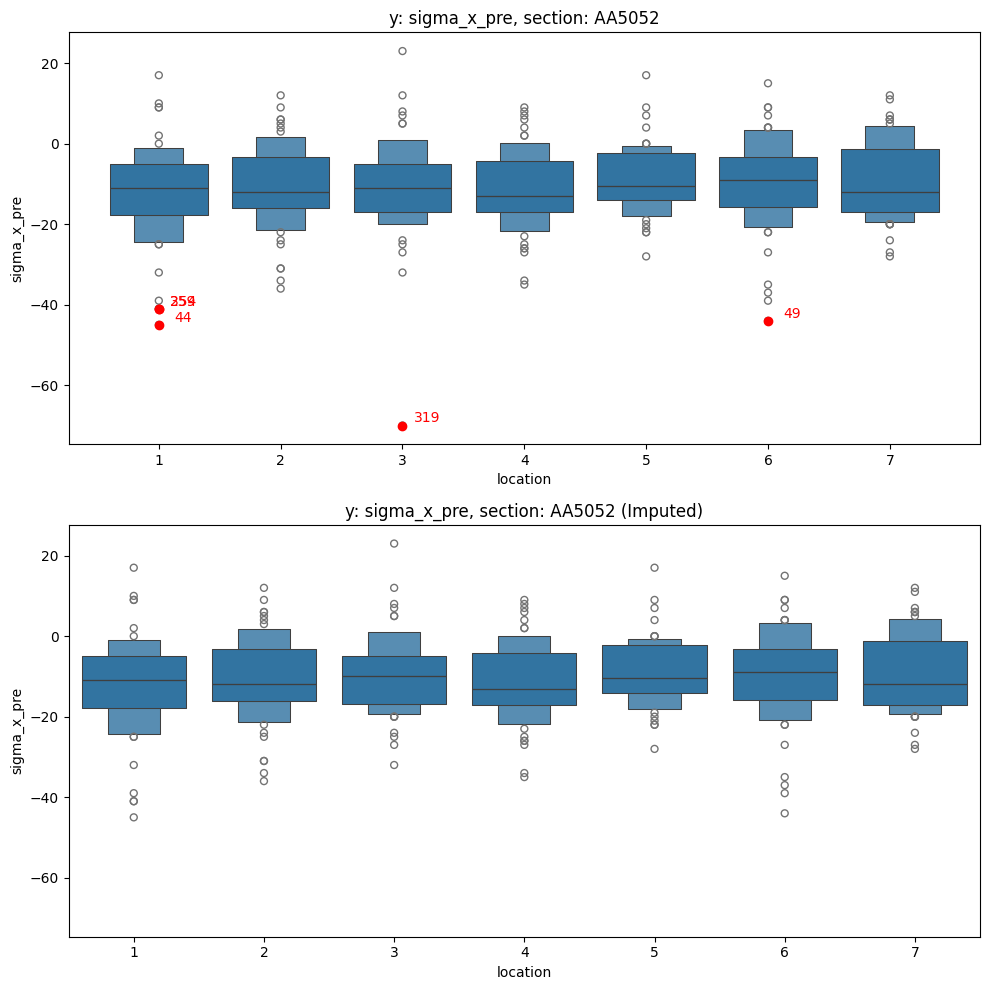

In [56]:
section = "AA5052"
y = "sigma_x_pre"
max_val = 150
min_val = -40
impute_idx_excels = [319]

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,sigma_x_pre,idx_excel_pre
744,AA6061,43,5,-109,300
553,AA6061,14,4,-92,96
226,AA6061,11,2,-85,73
746,AA6061,45,5,-83,314
216,AA6061,1,2,-79,3
391,AA6061,14,3,-78,95
874,AA6061,11,6,-77,77
565,AA6061,26,4,-76,180
722,AA6061,21,5,-73,146
269,AA6061,54,2,-72,374


Imputing idx_excel 48 at location 5, section AA6061 with mean value: 27.169811320754718


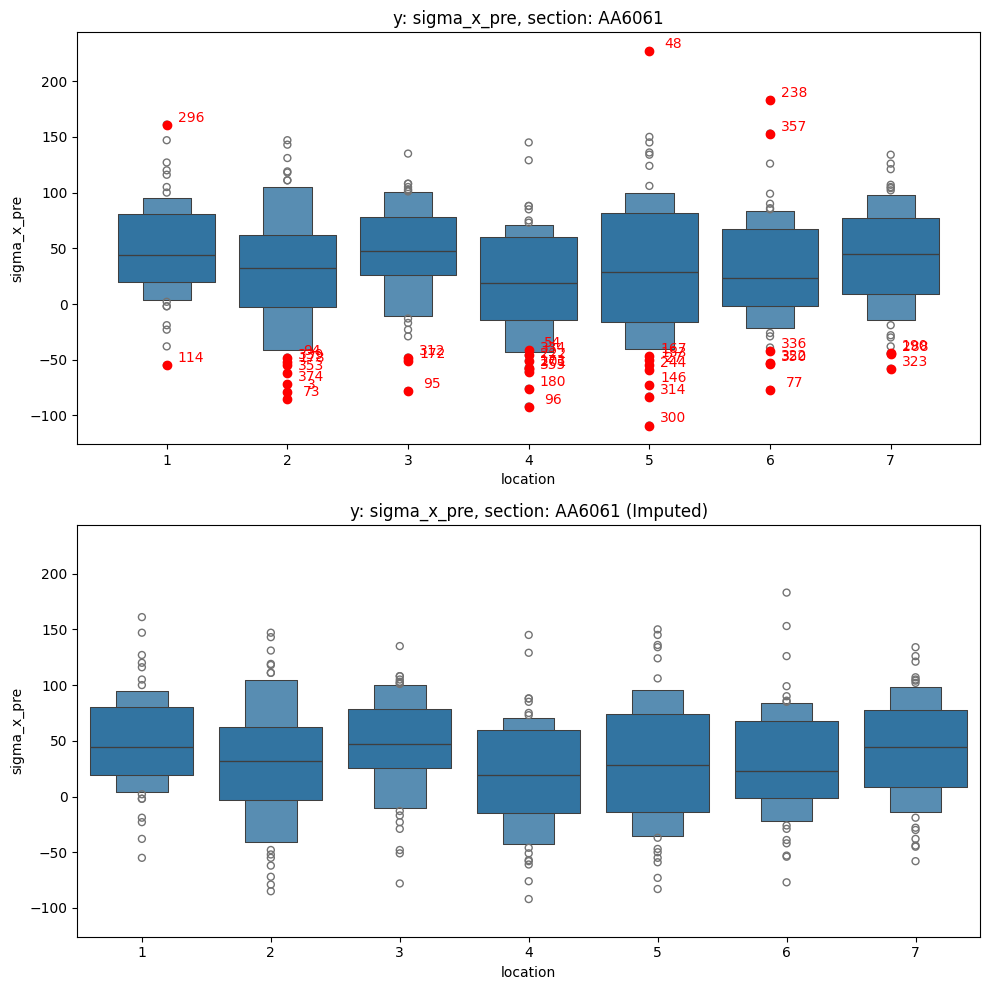

In [57]:
section = "AA6061"
y = "sigma_x_pre"
max_val = 150
min_val = -40
impute_idx_excels = [48]

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,sigma_x_post,idx_excel_post
997,AA5052,26,7,-34,547
329,AA5052,6,3,-31,115
198,AA5052,37,2,-27,763
661,AA5052,14,5,-23,289
837,AA5052,28,6,-22,586
212,AA5052,51,2,-21,1057
993,AA5052,22,7,54,463
47,AA5052,48,1,54,991
698,AA5052,51,5,60,1066


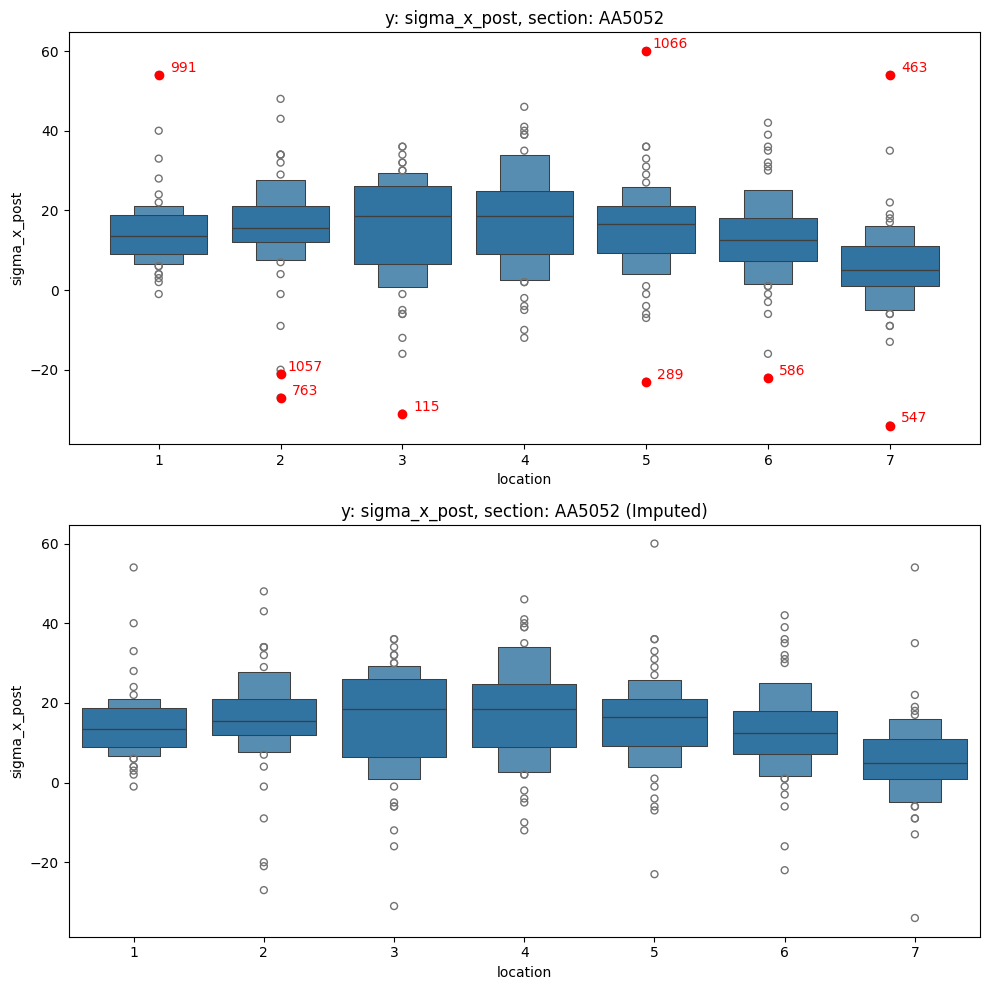

In [58]:
section = "AA5052"
y = "sigma_x_post"
max_val = 50
min_val = -20
impute_idx_excels = []

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,sigma_x_post,idx_excel_post
1038,AA6061,13,7,-122,272
1026,AA6061,1,7,-90,20
416,AA6061,39,3,-56,806
1065,AA6061,40,7,-54,839
888,AA6061,25,6,-52,521
406,AA6061,29,3,-44,596
877,AA6061,14,6,-44,290
562,AA6061,23,4,-41,473


Imputing idx_excel 272 at location 7, section AA6061 with mean value: 12.057692307692308
Imputing idx_excel 20 at location 7, section AA6061 with mean value: 12.057692307692308


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17180\969618660.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.057692307692308' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfm_imputed.loc[idx, y] = mean_val


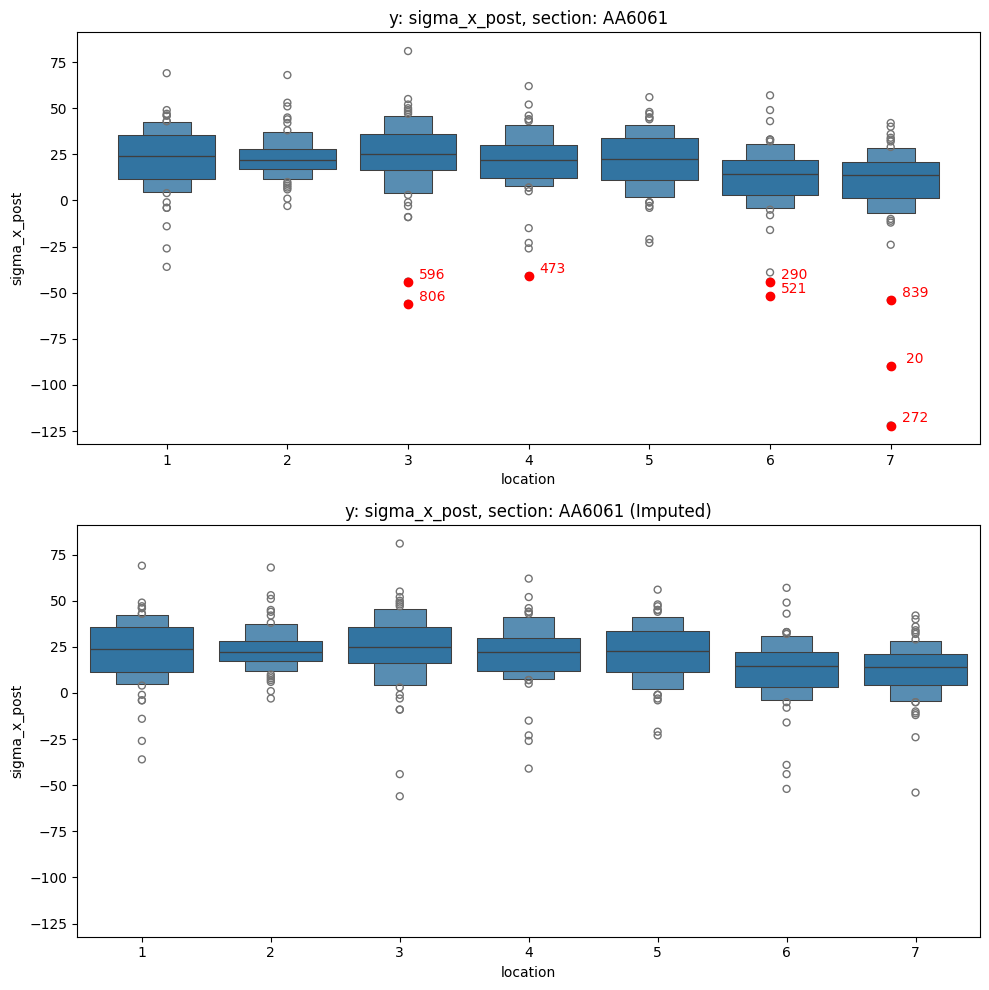

In [59]:
section = "AA6061"
y = "sigma_x_post"
max_val = 150
min_val = -40
impute_idx_excels = [272, 20]

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,sigma_x_post,idx_excel_post
792,Center,37,5,-29,771
307,Center,38,2,-16,783
936,Center,19,6,-6,396
1088,Center,9,7,-5,189
968,Center,51,6,-3,1068
933,Center,16,6,-3,333
954,Center,37,6,-2,774
927,Center,10,6,-2,207
1098,Center,19,7,-2,399
932,Center,15,6,-1,312


Imputing idx_excel 783 at location 2, section Center with mean value: 13.943396226415095
Imputing idx_excel 771 at location 5, section Center with mean value: 11.075471698113208


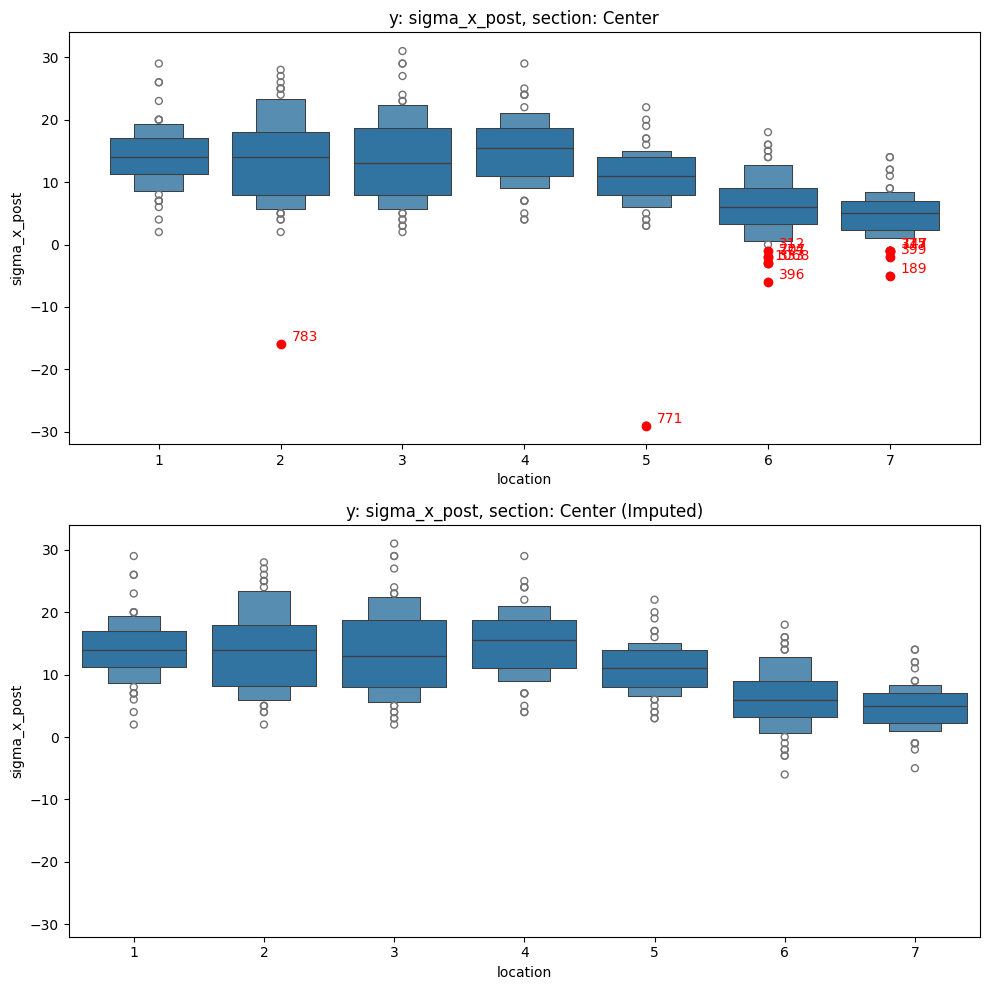

In [60]:
section = "Center"
y = "sigma_x_post"
max_val = 150
min_val = 0
impute_idx_excels = [783,771]

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,FWHM_pre,idx_excel_pre


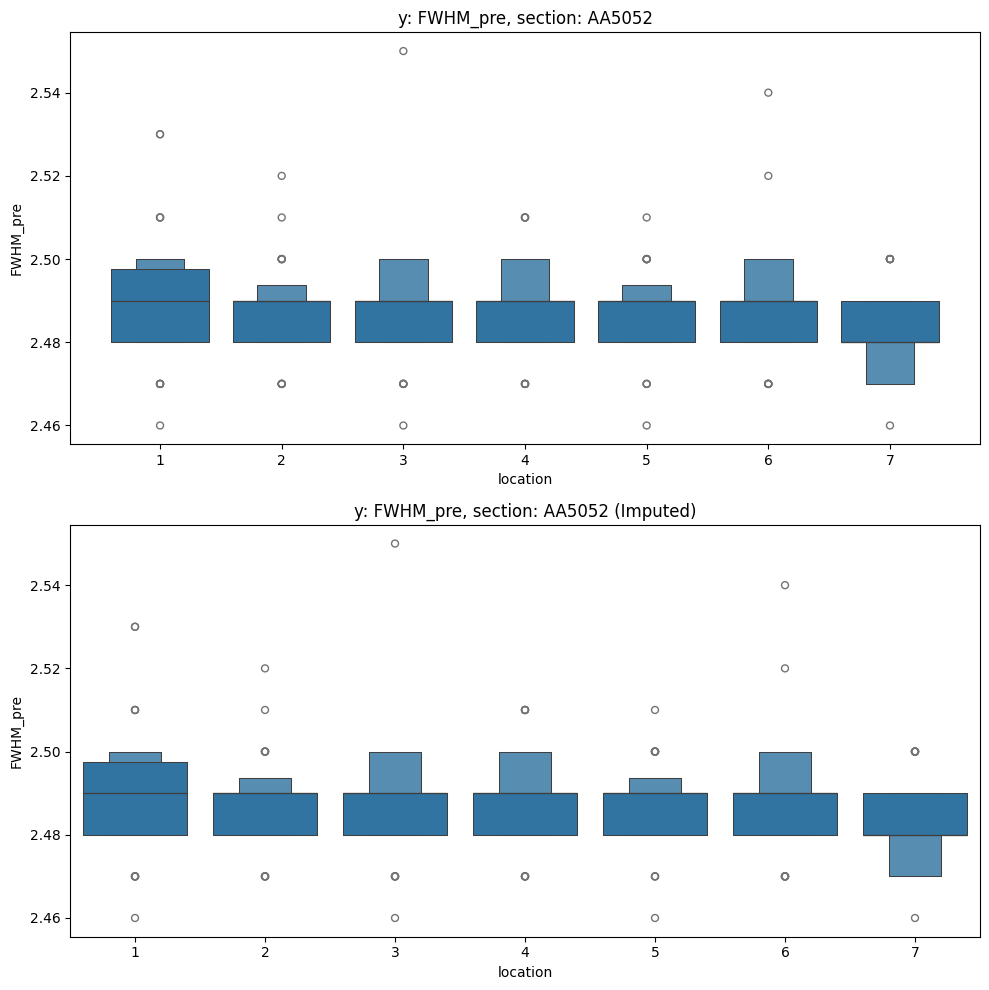

In [61]:
section = "AA5052"
y = "FWHM_pre"
max_val = 150
min_val = -40
impute_idx_excels = []

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,FWHM_pre,idx_excel_pre


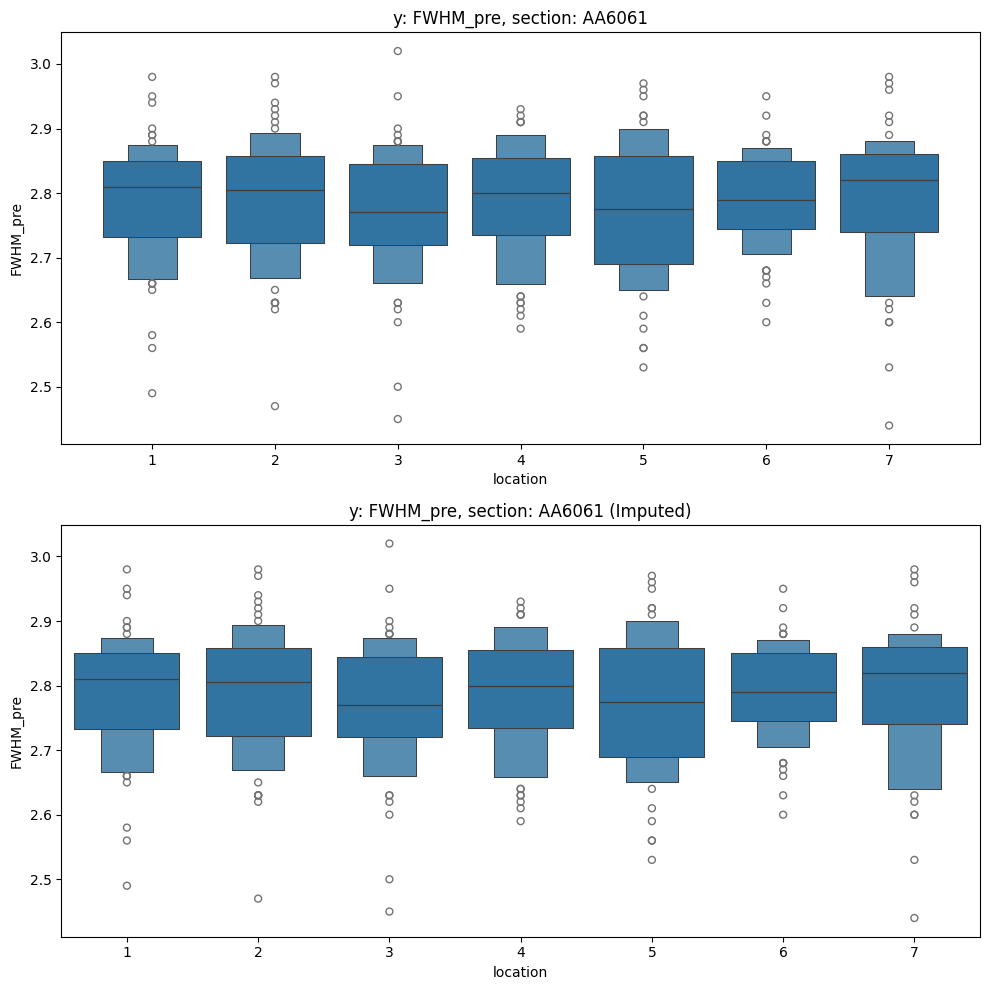

In [62]:
section = "AA6061"
y = "FWHM_pre"
max_val = 150
min_val = 1
impute_idx_excels = []

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,FWHM_post,idx_excel_post
329,AA5052,6,3,2.74,115


Imputing idx_excel 115 at location 3, section AA5052 with mean value: 2.489056603773585


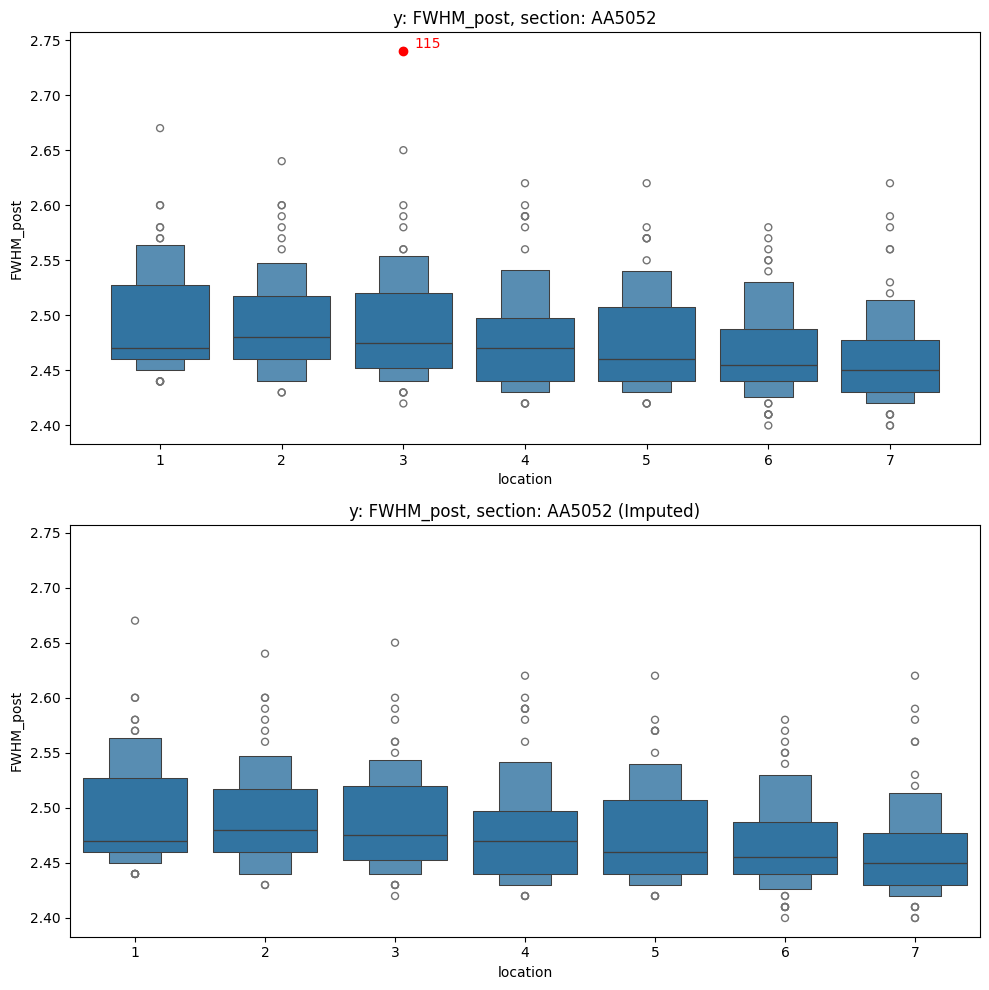

In [63]:
section = "AA5052"
y = "FWHM_post"
max_val = 2.70
min_val = 1
impute_idx_excels = [115]

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,FWHM_post,idx_excel_post
1065,AA6061,40,7,3.09,839


Imputing idx_excel 839 at location 7, section AA6061 with mean value: 2.61754716981132


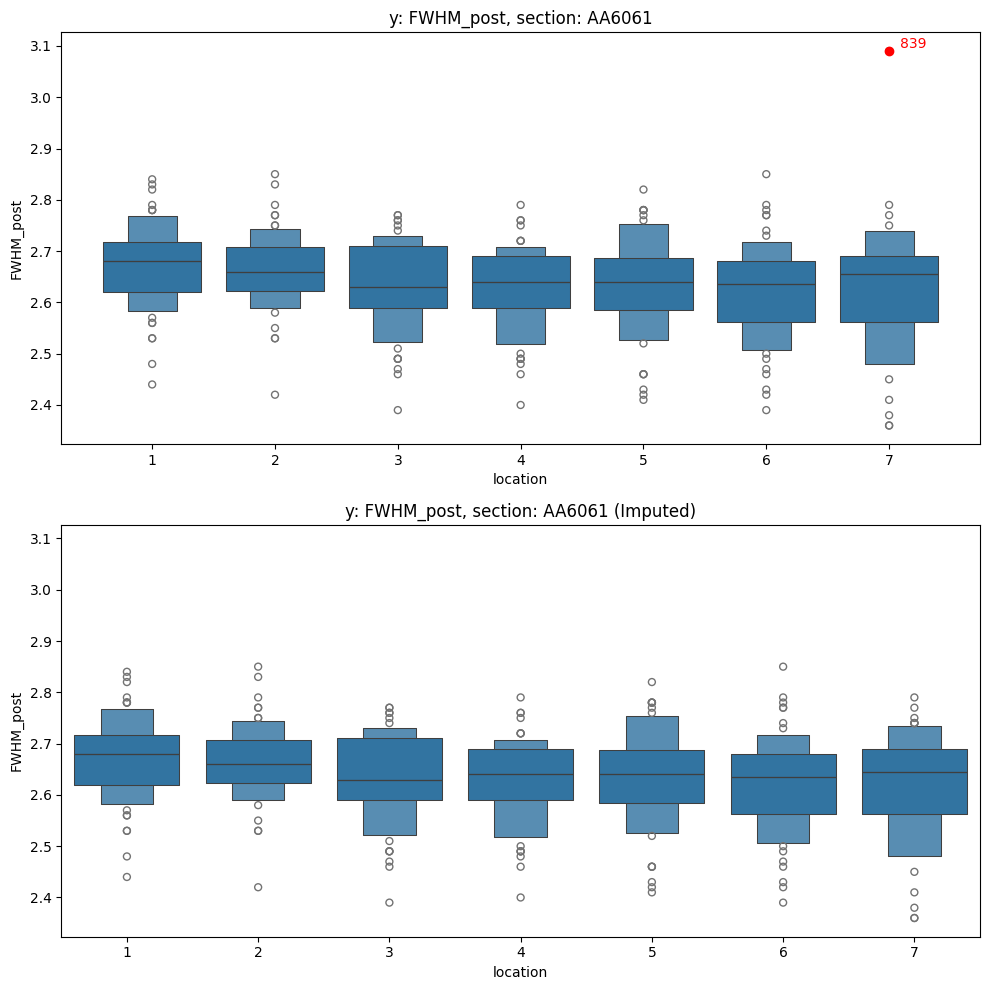

In [64]:
section = "AA6061"
y = "FWHM_post"
max_val = 2.90
min_val = 1
impute_idx_excels = [839]

outlier(section, y, max_val, min_val, impute_idx_excels)

,section,sample_no,location,FWHM_post,idx_excel_post
432,Center,1,3,2.76,9


Imputing idx_excel 9 at location 3, section Center with mean value: 2.502641509433962


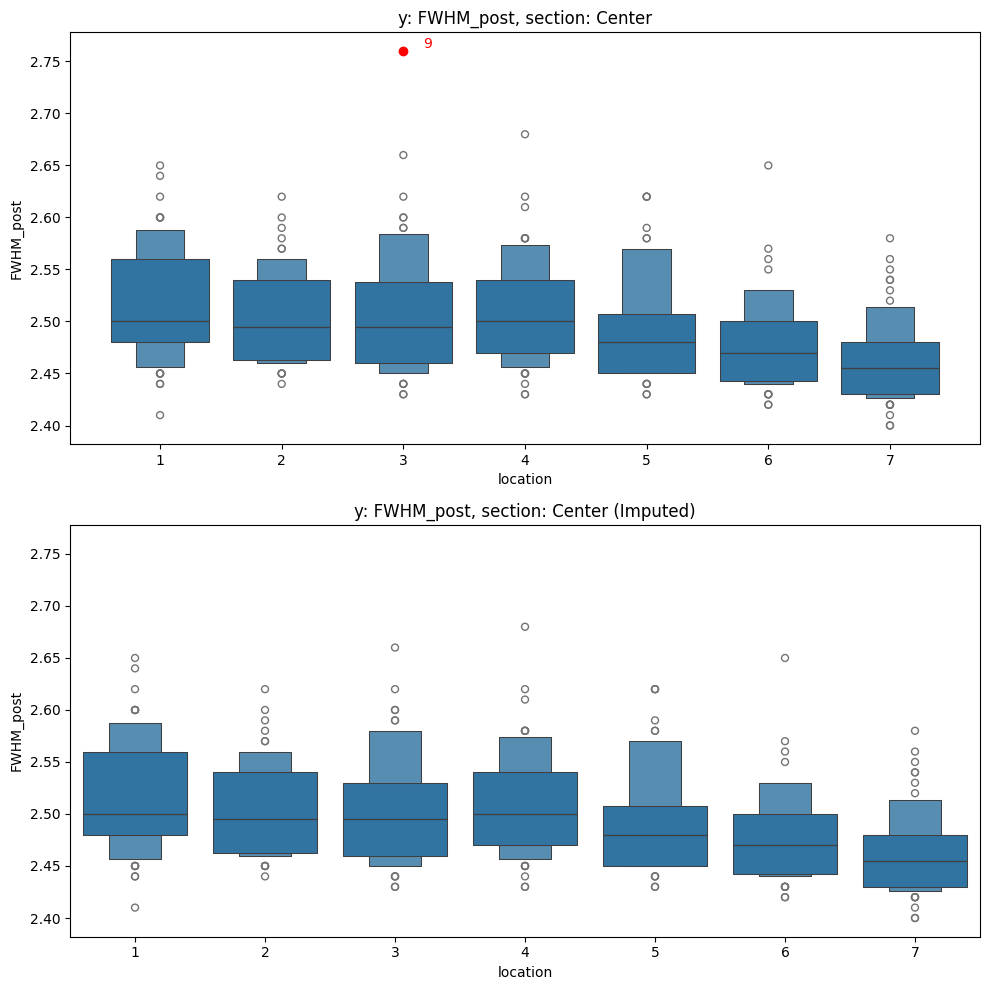

In [65]:
section = "Center"
y = "FWHM_post"
max_val = 2.70
min_val = 1
impute_idx_excels = [9]

outlier(section, y, max_val, min_val, impute_idx_excels)

In [66]:
from datetime import datetime
os.makedirs("S04", exist_ok=True)
dt = datetime.now().strftime("%Y%m%d_%H%M%S")
print(dt)

20251222_105458


In [67]:
dfm_imputed.to_excel(f"S04/S04_residual_stress_imputed_{dt}.xlsx", index=False)